In [ ]:
import pandas as pd 
from bioservices.kegg import KEGG
import numpy as np
import deepchem
import matplotlib.pyplot as plt


Creating directory /root/.config/bioservices 


Import colerectal cancer datasets. Source: https://www.nature.com/articles/s41591-019-0458-7#data-availability
- We are using metabolomic data from 149 Healthy, 45 MP(Multiple polypoid adenomas with low-grade dysplasia), 30 Stage 0, 80 stage I/II, 68 stage III/IV, and 34 HS (Healthy with a history of colorectal surgery) patients
- For each patient, we have metabolite profiles, which is the amount of each metabolite present
- We also have clinical info for each patient (used for classification)


In [ ]:
#Start writing co_1_7 = pd.ExcelFile('/work/beng212_1_7.xlsx')
_1_7 = pd.ExcelFile('/work/beng212_1_7 (1).xlsx')
population_dist = pd.read_excel(_1_7,sheet_name = 'population_dist',header = 0)
#metagenome_dem = pd.read_excel(_1_7,sheet_name = 'metagenome_demographics',header = 0)
metabolome_dem = pd.read_excel(_1_7,sheet_name = 'metabolome_demographics',header = 0)
#metagenome_clinical = pd.read_excel(_1_7,sheet_name = 'metagenome_clinical',header = 0)
metabolome_clinical = pd.read_excel(_1_7,sheet_name = 'metabolome_clinical',header = 0)
charged_metabolites = pd.read_excel(_1_7,sheet_name = 'charged_metabolites_list',header = 0)
#kegg_codes = pd.read_excel(_1_7,sheet_name = 'kegg_codes',header = 0)
kegg_orth_ids = pd.read_excel(_1_7,sheet_name = 'kegg_orth_IDs',header = 0)
metabolite_profiles = pd.read_excel("/work/paper_data.xlsx", sheet_name = 'Table_S13', header = 0, skiprows = lambda x: x in [0,1,2])
metabolite_profiles=metabolite_profiles.rename(columns={'Unnamed: 0':'Metabolites'})
#metagenomic_data = pd.read_excel(_1_7,sheet_name = 'patient_metagenomic_data',header = 0)de here...
metabolome_dem

,Characteristics,Healthy,MP,Stage 0,Stage I/II,Stage III/IV,HS,P-value,Statistical test
0,Number of subjects,149,45,30,80,68,34,NaN,NaN
1,Age (years),64.11+-10.9,64.36+-8.45,63.73+-8.77,63.58+-8.84,59.5+-11.46,60.56+-11.92,0.03923,Kruskal-Wallis rank sum test
2,Gender (M/F),1900-01-03 15:03:00,1900-01-01 11:10:00,15:15:00,1900-01-02 04:28:00,1900-01-01 12:32:00,16:18:00,0.03619,Pearson's Chi-squared test
3,BMI (kg/m2),23.78+-11.17,23.26+-3.39,23.94+-3.88,22.77+-3.34,22.94+-3.31,22.86+-3.16,0.79310,Kruskal-Wallis rank sum test
4,Brinkman Index,372.89+-554.4,507.38+-455.59,499.3+-623.03,478.92+-560.4,319.13+-403.99,241.44+-375.58,0.01838,Kruskal-Wallis rank sum test
5,Alcohol (g/day),258.48+-382.73,337.47+-444.06,174.74+-303.74,290.67+-382.39,196.73+-375.66,206.3+-354.92,0.05801,Kruskal-Wallis rank sum test


In [ ]:
metabolite_profiles

,Metabolites,10021,10023,10025,10029,10031,10033,10034,10036,10037,...,10829,10839,10847,10848,10178,10171,10119,10435,10469,10495
0,C00024_Acetyl CoA,102.420732,0.000000,90.176705,0.000000,38.328137,49.050811,0.000000,0.000000,78.598859,...,15.803806,0.000000,12.292788,8.973604,30.043355,0.000000,0.000000,0.000000,0.000000,26.465340
1,C01996_Acetylcholine,3.005386,2.817995,1.580793,0.879373,1.296656,0.000000,0.000000,3.655592,0.771784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,C00147_Adenine,8.117575,13.490150,13.094214,27.859706,17.676669,10.485603,8.323358,17.281261,11.963723,...,14.600985,34.608866,7.176766,9.070102,11.292698,0.000000,9.170705,23.300225,5.837965,10.528296
3,C00212_Adenosine,25.825384,51.678173,76.001952,42.646169,36.309848,41.065028,13.133139,20.391655,39.113220,...,104.087485,14.817901,9.967577,54.978360,65.801492,23.625711,6.807764,12.116699,22.532718,118.135381
4,"C00054_Adenosine 3',5'-diphosphate",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,C01020_6-Hydroxynicotinate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.347383,103.605626,0.000000,0.000000
446,C08434_6-Methylaminopurine,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
447,"C02953_7,8-Dihydrobiopterin",3.051459,3.633562,15.663284,0.000000,26.247682,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
448,"C04874_7,8-Dihydroneopterin",0.000000,0.000000,0.000000,16.829944,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.992352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Build base tables for experiments. 
- kegg_metabolites has all the metabolites in the profiles
- info has the dictionary with all the information for each metabolite 
- graph_rep stores the metaboliote-metabolite interaction between two metabolites to create an undirected graph 
    - nodes are the metabolites 
    - edge_length is the inverse of the number of overlapping pathways 

In [ ]:
kegg_metabolites = charged_metabolites[['KEGG Compound ID','Name of Metabolite']].dropna(axis = 0)
ids = pd.Series(kegg_metabolites['KEGG Compound ID']) 
def unravel_info(cell):
    return kegg.parse(kegg.get(cell))
info = ids.apply(unravel_info)
info.to_csv('metabolite_info.csv')

NameError: name 'kegg' is not defined

In [ ]:
def find_edge(mol1, mol2):
    c = 0
    pathways = []
    for i in mol1:
        for j in mol2: 
            if i == j:
                c += 1
                pathways.append(mol1[i])
    return c, pathways


In [ ]:
graph_rep = {}
for i in range(len(info)):
    for j in range(len(info)):
        print(i,j)
        if ("PATHWAY" in info[i]) and ("PATHWAY" in info[j]):
            if (i in graph_rep) and ( j in graph_rep[i]):
                graph_rep.update({info[j]['ENTRY'].split(" ")[0]: {info[i]['ENTRY'].split(" ")[0]: graph_rep[i][j]}})
            elif (j in graph_rep) and ( i in graph_rep[j]):
                graph_rep.update({info[i]['ENTRY'].split(" ")[0]: {info[j]['ENTRY'].split(" ")[0]: graph_rep[j][i]}})
            else:
                mol1 = info[i]['PATHWAY']
                mol2 = info[j]['PATHWAY']
                if i == j:
                    graph_rep.update({info[i]['ENTRY'].split(" ")[0]:{info[i]['ENTRY'].split(" ")[0]:{'edge_length':0,'pathways':[i for i,k in mol1.items()]}}})
                else: 
                    c,pathway = find_edge(mol1, mol2)
                    graph_rep.update({info[i]['ENTRY'].split(" ")[0]:{info[j]['ENTRY'].split(" ")[0]:{'edge_length':(1/c if c != 0 else 0), 'pathways': pathway}}})

In [ ]:
with open('metabolite_interactions.txt', 'w') as f:
    print(graph_rep, file=f)

In [ ]:
metabolite_profiles

,Metabolites,10021,10023,10025,10029,10031,10033,10034,10036,10037,...,10829,10839,10847,10848,10178,10171,10119,10435,10469,10495
0,C00024_Acetyl CoA,102.420732,0.000000,90.176705,0.000000,38.328137,49.050811,0.000000,0.000000,78.598859,...,15.803806,0.000000,12.292788,8.973604,30.043355,0.000000,0.000000,0.000000,0.000000,26.465340
1,C01996_Acetylcholine,3.005386,2.817995,1.580793,0.879373,1.296656,0.000000,0.000000,3.655592,0.771784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,C00147_Adenine,8.117575,13.490150,13.094214,27.859706,17.676669,10.485603,8.323358,17.281261,11.963723,...,14.600985,34.608866,7.176766,9.070102,11.292698,0.000000,9.170705,23.300225,5.837965,10.528296
3,C00212_Adenosine,25.825384,51.678173,76.001952,42.646169,36.309848,41.065028,13.133139,20.391655,39.113220,...,104.087485,14.817901,9.967577,54.978360,65.801492,23.625711,6.807764,12.116699,22.532718,118.135381
4,"C00054_Adenosine 3',5'-diphosphate",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,C01020_6-Hydroxynicotinate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.347383,103.605626,0.000000,0.000000
446,C08434_6-Methylaminopurine,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
447,"C02953_7,8-Dihydrobiopterin",3.051459,3.633562,15.663284,0.000000,26.247682,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
448,"C04874_7,8-Dihydroneopterin",0.000000,0.000000,0.000000,16.829944,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.992352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
healthy = metabolite_profiles[metabolome_clinical.loc[metabolome_clinical.Group.isin(['Healthy', 'MP','HS'])]['Subject_ID']]
corr = healthy.transpose().corr()
corr

,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,1.000000,0.169928,0.056189,-0.158896,0.024266,-0.048313,0.079842,0.176378,0.699779,0.047287,...,0.131288,0.421307,-0.083946,0.072138,-0.147961,0.107352,-0.048313,0.078237,-0.028097,0.051901
1,0.169928,1.000000,-0.015817,0.022760,-0.027100,0.016966,0.082403,0.124260,0.122624,0.717578,...,0.039231,0.013497,0.103443,-0.025759,-0.119407,0.019206,-0.025907,0.117369,-0.013531,0.043555
2,0.056189,-0.015817,1.000000,0.111795,0.025258,-0.042238,0.055553,0.072863,0.011783,0.040117,...,-0.014299,0.301144,-0.035465,0.128958,0.004500,0.034200,-0.067236,0.008226,0.007721,0.155889
3,-0.158896,0.022760,0.111795,1.000000,0.010825,0.222386,-0.050600,0.062363,-0.067154,-0.041278,...,0.031403,0.059110,0.004960,-0.022756,-0.089321,0.061170,-0.041695,-0.051534,-0.043337,0.117908
4,0.024266,-0.027100,0.025258,0.010825,1.000000,-0.006243,0.019071,-0.037429,0.007935,-0.006243,...,-0.023751,0.041726,-0.017695,0.283120,-0.012970,-0.035821,-0.006243,-0.041906,-0.011688,-0.132321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.107352,0.019206,0.034200,0.061170,-0.035821,-0.025276,0.275108,0.003157,0.145571,-0.025276,...,0.038745,-0.005520,-0.081996,-0.065640,-0.080967,1.000000,-0.025276,-0.034433,-0.047320,0.254559
446,-0.048313,-0.025907,-0.067236,-0.041695,-0.006243,-0.004405,-0.028216,-0.051671,-0.055712,-0.004405,...,-0.016760,-0.064466,0.079667,-0.018040,-0.023888,-0.025276,1.000000,0.144492,-0.008247,0.048158
447,0.078237,0.117369,0.008226,-0.051534,-0.041906,-0.029570,-0.096625,0.453678,0.084081,-0.029570,...,-0.033390,0.082618,0.373010,-0.045222,-0.119475,-0.034433,0.144492,1.000000,-0.055359,0.171496
448,-0.028097,-0.013531,0.007721,-0.043337,-0.011688,-0.008247,0.018582,0.049708,-0.053803,-0.008247,...,0.040169,0.034694,-0.017342,0.044761,0.015957,-0.047320,-0.008247,-0.055359,1.000000,0.031227


In [ ]:
cancer = metabolite_profiles[metabolome_clinical.loc[~metabolome_clinical.Group.isin(['Healthy','MP','HS'])]['Subject_ID']]
corr = cancer.transpose().corr()



,0,1,2,3,4,5,6,7,8,9,...,440,441,442,443,444,445,446,447,448,449
0,1.000000,0.168058,-0.044223,-0.107360,NaN,NaN,0.067734,0.012620,0.582511,NaN,...,-0.003748,0.412666,0.041715,-0.066925,-0.113464,-0.024169,NaN,-0.063845,-0.071922,0.027888
1,0.168058,1.000000,-0.044032,0.145264,NaN,NaN,-0.033112,0.088102,0.118502,NaN,...,0.132078,-0.003781,0.182620,-0.066353,-0.091358,-0.026005,NaN,0.071148,0.076605,0.072087
2,-0.044223,-0.044032,1.000000,0.105263,NaN,NaN,0.058962,0.117467,0.056634,NaN,...,-0.047069,0.168286,0.211975,0.055120,-0.004015,0.128206,NaN,0.164299,0.190605,0.237427
3,-0.107360,0.145264,0.105263,1.000000,NaN,NaN,-0.051825,0.016175,-0.079384,NaN,...,-0.089606,0.099367,0.016304,0.021946,-0.021021,-0.032217,NaN,-0.022134,-0.045074,0.033313
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,-0.024169,-0.026005,0.128206,-0.032217,NaN,NaN,0.061674,0.005350,-0.015736,NaN,...,-0.033347,0.015640,0.007080,0.013204,-0.054127,1.000000,NaN,-0.000917,-0.001356,0.048341
446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
447,-0.063845,0.071148,0.164299,-0.022134,NaN,NaN,0.166313,0.800959,-0.015154,NaN,...,0.039871,0.367831,0.747815,-0.051126,-0.043913,-0.000917,NaN,1.000000,0.922491,0.854526
448,-0.071922,0.076605,0.190605,-0.045074,NaN,NaN,0.210185,0.837469,-0.057537,NaN,...,0.055670,0.387290,0.684970,-0.034505,-0.005896,-0.001356,NaN,0.922491,1.000000,0.820934


In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split as tts

In [ ]:

X_train, X_test, y_train, y_test = tts(x,y, test_size=0.3, random_state=0)
lr= LR(max_iter = 1000000000)

NameError: name 'tts' is not defined

In [ ]:
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000000000)

In [ ]:
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [ ]:

#X_train, X_test, y_train, y_test = trai(X, y, test_size=0.3, random_state=0)
x = metabolite_profiles.transpose()
x = x.rename(columns=x.iloc[0])
x = x.drop(x.index[0])
x = x.sort_index(axis = 0)

In [ ]:
metabolome_clinical= metabolome_clinical.set_index(metabolome_clinical['Subject_ID'])
y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')

In [ ]:
y.unique()

array(['Cancer', 'Healthy'], dtype=object)

In [ ]:
#Find the rows in the healthy data which contain more than .5% of entries 0 
#(can change amount you're dividing by, but for some reason any value less than like 20 causes logistic regression to fail)
mostly_non_zero_healthy = healthy[(healthy == 0).sum(axis=1)>=len(healthy.columns)].index
#Find the rows in the cancer data which contain more than .5% of entries 0
mostly_non_zero_cancer = cancer[(cancer == 0).sum(axis=1)>=len(cancer.columns)].index 
#Take union of the rows mentioned above
mostly_non_zero = mostly_non_zero_healthy.union(mostly_non_zero_cancer)
#Drop the rows (metabolites) which contain more than .5% of entries 0
mod_data = metabolite_profiles.drop(mostly_non_zero,axis=0)

metabolome_clinical= metabolome_clinical.set_index(metabolome_clinical['Subject_ID'])
y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')

mod_x = mod_data.transpose()
mod_x = mod_x.rename(columns=mod_x.iloc[0])
mod_x = mod_x.drop(mod_x.index[0])
mod_x = mod_x.sort_index(axis = 0)
X_train, X_test, y_train, y_test = tts(mod_x,y, test_size=0.3, random_state=0)

lr= LR(max_iter = 100000000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [ ]:
mod_data

,Metabolites,10021,10023,10025,10029,10031,10033,10034,10036,10037,...,10829,10839,10847,10848,10178,10171,10119,10435,10469,10495
0,C00024_Acetyl CoA,102.420732,0.000000,90.176705,0.000000,38.328137,49.050811,0.000000,0.000000,78.598859,...,15.803806,0.000000,12.292788,8.973604,30.043355,0.000000,0.000000,0.000000,0.000000,26.465340
1,C01996_Acetylcholine,3.005386,2.817995,1.580793,0.879373,1.296656,0.000000,0.000000,3.655592,0.771784,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,C00147_Adenine,8.117575,13.490150,13.094214,27.859706,17.676669,10.485603,8.323358,17.281261,11.963723,...,14.600985,34.608866,7.176766,9.070102,11.292698,0.000000,9.170705,23.300225,5.837965,10.528296
3,C00212_Adenosine,25.825384,51.678173,76.001952,42.646169,36.309848,41.065028,13.133139,20.391655,39.113220,...,104.087485,14.817901,9.967577,54.978360,65.801492,23.625711,6.807764,12.116699,22.532718,118.135381
4,"C00054_Adenosine 3',5'-diphosphate",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,C01020_6-Hydroxynicotinate,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.347383,103.605626,0.000000,0.000000
446,C08434_6-Methylaminopurine,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
447,"C02953_7,8-Dihydrobiopterin",3.051459,3.633562,15.663284,0.000000,26.247682,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
448,"C04874_7,8-Dihydroneopterin",0.000000,0.000000,0.000000,16.829944,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.992352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#Same as before, this time drop the rows from healthy and cancer data respectively
mod_healthy = healthy.drop(mostly_non_zero,axis=0)
mod_cancer = cancer.drop(mostly_non_zero,axis=0)
corr_mod_healthy = mod_healthy.transpose().corr()
corr_mod_cancer = mod_cancer.transpose().corr()

#Correlations which differ in a statistically significant manner
for row in range(0,len(corr_mod_cancer.columns)):
    for col in range(0,row):
        p = independent_corr( corr_mod_healthy.iloc[row,col], corr_mod_cancer.iloc[row,col], 228, 178, twotailed=True, method='fisher')
        if (p[1] <= .0001):
          print(p[1])
          print(corr_mod_healthy.iloc[row,col]-corr_mod_cancer.iloc[row,col])
          print(row,col)

2.506031637761197e-07
0.04170454624650388
13 12
2.4702575522228543e-05
-0.375136341522382
16 11
9.351285704894963e-06
0.3819311267601966
17 1
3.886182797785409e-07
-0.40060166907752903
17 4
1.2880291149874878e-05
-0.2901014829042226
19 16
5.004945420861162e-05
0.29032257694020325
20 5
8.360289233566576e-06
0.06419134172478025
21 15


In [ ]:
mod_cancer


,10033,10047,10055,10081,10134,10140,10154,10165,10177,10198,...,10760,10761,10765,10772,10813,10818,10822,10839,10847,10848
3,41.065028,18.899875,22.808581,36.830076,19.891980,22.810335,73.249838,11.310556,39.798566,83.579810,...,52.487817,73.927778,94.390316,735.605199,47.897706,35.279790,128.048958,14.817901,9.967577,54.978360
25,1623.731743,682.509032,828.028766,529.857611,122.637761,817.178886,876.337677,286.304819,1206.203774,1365.023917,...,1906.564119,1504.045324,629.170667,2267.099479,674.447063,808.837913,983.802234,171.694933,291.492504,608.067251
29,7434.991245,5695.970431,5238.115534,1733.492693,979.347688,719.328279,3857.353491,695.445747,5969.403041,2261.827846,...,5407.642608,6834.135953,3360.512644,10462.183780,3089.550764,1235.820316,5765.581811,1224.638710,1142.740661,4302.836852
35,194.960014,68.017872,1015.385387,149.973973,135.631896,214.108983,155.654516,65.681248,1355.154057,118.118961,...,761.628442,57.175376,275.598414,157.641854,51.319360,397.346140,1093.269951,26.313291,97.266442,81.320804
47,201.473541,86.579497,91.465387,223.812835,177.437342,3953.886532,401.871700,22.828033,32.369682,407.002774,...,104.284643,183.175340,86.370026,146.679987,947.891831,377.101218,133.573503,66.437912,28.714623,23.985675
54,359.306519,274.258568,1186.177949,496.853531,536.517139,826.206218,2081.778367,110.128695,228.438715,1144.365941,...,402.263792,532.529711,533.593638,525.094123,293.704771,694.062115,707.930396,88.326797,35.469251,221.033882
59,653.747403,395.063854,160.356865,596.183006,770.627022,314.547784,2472.574706,232.174986,449.946018,3527.802073,...,819.120679,870.531079,2250.719246,805.024307,602.851861,570.009626,888.460760,273.034574,252.162191,240.679316
82,42.606018,49.135683,99.982968,64.396146,77.267516,358.282252,57.571641,91.797528,76.657171,693.099712,...,19.711714,85.811982,79.688705,72.937521,38.768433,18.581369,57.202024,41.166207,64.994823,55.624505
105,1711.639881,734.755154,146.452676,477.285275,654.179386,328.798089,919.099080,153.647081,1037.356736,1059.592612,...,1441.430097,634.965687,1295.213454,939.853595,281.190101,644.212337,2369.576710,261.592481,201.445219,1486.918541
110,31178.589570,20728.528530,9548.201193,4789.808347,5425.612666,2037.854674,21319.823210,9535.194903,19832.624910,6337.573058,...,15663.570020,20915.063720,13839.362570,24405.487200,14120.030830,7245.603384,20586.324020,10189.814580,8419.038483,11403.002580


In [ ]:
import scipy
#Metabolite sample distributions which differ in significant manner
for i in range(0,len(corr_mod_cancer.columns)):
  p = scipy.stats.ks_2samp(mod_healthy.iloc[i,:],mod_cancer.iloc[i,:],alternative='two-sided')[1]
  if p < .0001:
    print(p)
    print(i)


1.2678544440758444e-05
6
3.399067228782027e-05
13
4.91053862395896e-05
14
9.45271757413213e-06
15
1.139702753627514e-05
20


In [ ]:
#Statistically significant correlations, this becomes an adjacency matrix
Pval = calculate_pvalues(mod_cancer.transpose())
Pval[Pval<=.0001]=1
Pval[(Pval>.0001) & (Pval<1)] = 0
Pval


In [ ]:
calculate_pvalues(mod_x)

""


In [ ]:
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh
#from https://medium.com/@ph_singer/statistical-significance-tests-on-correlation-coefficients-b9397380be55
def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    else:
        raise Exception('Wrong method!')

from scipy.stats import pearsonr
#from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [ ]:
#data pre processing 
X = metabolite_profiles.transpose()
X = X.rename(columns=X.iloc[0])
X = X.loc[~(X==0).all(axis=1)]
X = X.drop(X.index[0])
X = X.sort_index(axis = 0)
Pval = calculate_pvalues(X.transpose())
Pval[Pval<=.0001]=1
Pval[(Pval>.0001) & (Pval<1)] = 0
Pval
y = metabolome_clinical.sort_index()['Group']
y = y.replace('Stage_III_IV','Cancer')
y = y.replace('Stage_I_II','Cancer')
y = y.replace('Stage_0','Cancer')
y = y.replace('MP','Healthy')
y = y.replace('HS','Healthy')
y = y.replace('Healthy', 1)
y = y.replace('Cancer', 2)


In [ ]:
import numpy as np
import pandas as pd
#import tensorflow as tf
import tensorflow.compat.v1 as tf
#tensorflow-gpu==1.15.0
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils as utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('/work/lib'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 1
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]; print('step2:', n_timesteps, n_features,n_outputs)
    model = Sequential(); print('setup model')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu',input_shape = (n_timesteps, n_features)));print('L1')
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu')); print('L2')
    model.add(Dropout(0.5)); print('L3')
    model.add(MaxPooling1D(pool_size=1)); print('L4')   
    model.add(Flatten()); print('flatten')
    model.add(Dense(100, activation='relu')); print('dense layer')
    model.add(Dense(n_outputs, activation='softmax')); print('final layer')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['binary_accuracy']); print('compile')
    #train_data = tf.data.Dataset.from_tensor_slices((trainX, trainy)); print('train_data')
    #valid_data = tf.data.Dataset.from_tensor_slices((testX, testy));print('tesr_data')
    #train_data = np.asarray(train_data).astype('float32')
    #valid_data = np.asarray(test_data).astype('float32')
    print('tryna fit')
    model.fit(trainX,trainy, epochs=epochs, batch_size=batch_size, verbose=verbose);  print('fit');
    a, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0);
    #return accuracy
    return a,accuracy

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.5)
X_test = np.expand_dims(X_test,axis = 0)
y_test = np.expand_dims(y_test, axis = 0)
X_train = np.expand_dims(X_train,axis = 0)
y_train = np.expand_dims(y_train, axis = 0)


In [ ]:
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test ).astype('float32')
y_test = np.asarray(y_test).astype('float32')
evaluate_model(X_train, y_train, X_test, y_test)

step2: 203 450 203
setup model
L1
L2
L3
L4
flatten
dense layer
final layer
compile
tryna fit
fit


(1492341632.0, 0.0)

In [ ]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 100
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = 2
# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = len(X_train) / params['batch_size']

NameError: name 'X_train' is not defined

In [ ]:
model = cgcnn(L,params['F'],params['K'],params['p'],params['M'])

#accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 472
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 472 * 32 / 4 = 3776
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 118 * 64 / 2 = 3776
    weights: F_1 * F_2 * K_2 = 32 * 64 * 20 = 40960
    biases: F_2 = 64
  layer 3: fc1
    representation: M_3 = 512
    weights: M_2 * M_3 = 3776 * 512 = 1933312
    biases: M_3 = 512
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 512 * 2 = 1024
    biases: M_4 = 2
Test
 K = 1
Test
 K = 1


ValueError: None values not supported.

In [ ]:
import tensorflow as tf
tf.version.VERSION

'2.4.1'

In [ ]:
from lib import graph,models,coarsening
import matplotlib.pyplot as plt

450
[  0   0   0 ... 449 449 449]
d = |V| = 450, k|V| < |E| = 8548


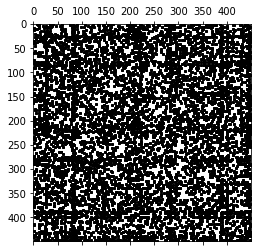

In [ ]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3)
X_train = np.asarray(X_train ).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test ).astype('float32')
y_test = np.asarray(y_test).astype('float32')
dist, idx = graph.distance_scipy_spatial(X_train.T, k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (450, 450)
print('d = |V| = {}, k|V| < |E| = {}'.format(450, A.nnz))
plt.spy(A, markersize=2, color='black');

In [ ]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)
#Any reason for coarsening into 3 levels? What's significance of levels?
#X_train = coarsening.perm_data(X_train, perm)
#X_test = coarsening.perm_data(X_test, perm)


TypeError: unsupported operand type(s) for -: 'list' and 'int'

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


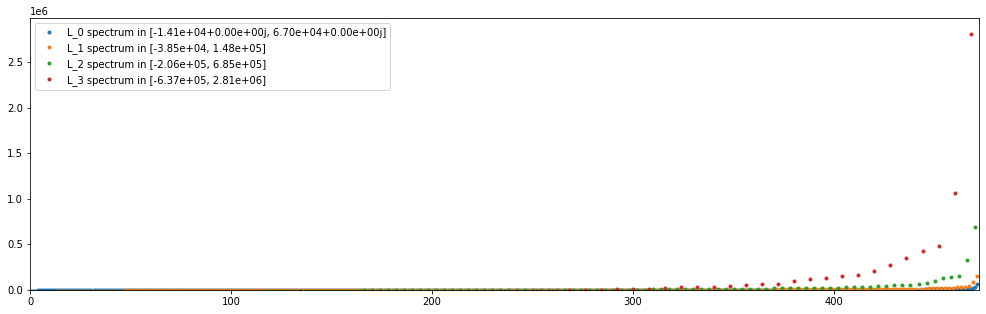

In [ ]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

In [ ]:
X_test

,C00024_Acetyl CoA,C01996_Acetylcholine,C00147_Adenine,C00212_Adenosine,"C00054_Adenosine 3',5'-diphosphate",C00224_Adenosine 5'-phosphosulfate,C06104_Adipate,C03626_ADMA,C00008_ADP,C00498_ADP-glucose,...,C00440_5-Methyltetrahydrofolate,C00170_5-Methylthioadenosine,C01879_5-Oxoproline,C02378_6-Aminohexanoate,C06103_6-Hydroxyhexanoate,C01020_6-Hydroxynicotinate,C08434_6-Methylaminopurine,"C02953_7,8-Dihydrobiopterin","C04874_7,8-Dihydroneopterin",C02242_7-Methylguanine
10238,0.0,1.84583,7.938355,20.619989,0.0,0.0,0.0,119.021948,62.409185,0.0,...,0.0,0.0,256.252914,0.0,0.0,0.0,0.0,26.043061,0.0,46.453549
10642,85.951694,4.344058,12.105613,17.197937,0.0,0.0,1334.919475,95.90898,52.585125,0.0,...,0.0,16.03361,0.0,6.586498,0.0,0.0,0.0,39.22696,0.0,55.060111
10678,0.0,0.0,41.189896,21.910248,0.0,0.0,787.334515,0.0,0.0,0.0,...,0.0,2.703627,299.121309,9.829966,254.545417,0.0,0.0,0.0,0.0,56.095256
10713,68.330993,0.528586,20.7909,61.271805,0.0,0.0,787.301251,30.346453,71.635071,0.0,...,19.231591,12.038064,0.0,0.0,0.0,29.330108,0.0,0.0,0.0,0.0
10762,31.737216,1.820573,16.675093,149.813096,0.0,0.0,331.796843,0.0,41.88561,0.0,...,0.0,13.722275,116.35237,33.228194,0.0,9.004647,0.0,0.0,0.0,116.180628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10548,19.934288,0.0,22.737789,61.71215,0.0,0.0,676.467884,0.0,0.0,0.0,...,66.682733,18.878032,203.298709,2.351592,2101.756257,0.0,0.0,0.0,5.28774,14.363153
10621,107.135962,0.630156,6.417518,12.3532,0.0,0.0,675.979879,35.553619,165.259329,0.0,...,0.0,9.803923,0.0,0.0,0.0,49.066226,0.0,0.0,0.0,30.295353
10353,0.0,1.337148,142.180431,157.910116,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.826388,132.101371,50.795622,0.0,0.0,0.0,0.0,0.0,63.252247
10418,41.777866,1.966466,9.732063,29.992645,0.0,0.0,55.829194,18.109463,24.116673,0.0,...,0.0,11.95587,0.0,4.328776,0.0,33.558718,0.0,0.0,0.0,60.593234


,C00024_Acetyl CoA,C01996_Acetylcholine,C00147_Adenine,C00212_Adenosine,"C00054_Adenosine 3',5'-diphosphate",C00224_Adenosine 5'-phosphosulfate,C06104_Adipate,C03626_ADMA,C00008_ADP,C00498_ADP-glucose,...,C00440_5-Methyltetrahydrofolate,C00170_5-Methylthioadenosine,C01879_5-Oxoproline,C02378_6-Aminohexanoate,C06103_6-Hydroxyhexanoate,C01020_6-Hydroxynicotinate,C08434_6-Methylaminopurine,"C02953_7,8-Dihydrobiopterin","C04874_7,8-Dihydroneopterin",C02242_7-Methylguanine
10152,0.0,1.639069,13.1072,33.34905,0.0,0.0,147.706073,133.439434,49.952084,0.0,...,158.91968,7.240726,176.749369,0.0,0.0,0.0,0.0,0.0,0.0,27.324911
10593,232.546061,3.068789,30.44741,89.044592,0.0,0.0,741.558222,24.051134,60.036854,0.0,...,0.0,24.916742,0.0,0.0,0.0,24.538511,0.0,0.0,0.0,86.277021
10432,98.414091,0.0,28.381951,149.158002,0.0,0.0,118.059951,9.383121,26.722028,0.0,...,0.0,9.215194,241.267743,9.721501,182.917477,0.0,0.0,0.0,0.0,0.0
10380,0.0,0.0,15.614237,19.54829,0.0,0.0,617.592944,4.021155,0.0,0.0,...,0.0,0.0,89.719752,18.979423,1440.002155,0.0,0.0,0.0,0.0,0.0
10464,91.487693,4.229517,14.312969,134.178962,0.0,0.0,303.651031,33.840685,54.408549,0.0,...,0.0,14.417538,2667.951159,0.0,0.0,0.0,0.0,0.0,0.0,125.380945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10448,24.546991,0.0,25.638011,44.97411,0.0,0.0,317.44473,18.036993,27.693452,0.0,...,0.0,11.630531,104.765502,0.0,104.932439,65.862645,0.0,0.0,0.0,126.002483
10201,100.830202,3.356938,0.0,35.997269,0.0,0.0,188.372792,27.221317,72.505062,0.0,...,133.034881,14.604019,440.814313,0.0,0.0,0.0,0.0,0.0,0.0,89.390621
10074,0.0,0.0,0.0,17.788733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.329774,55.812729,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10132,0.0,0.0,0.0,3.777405,0.0,0.0,0.0,15.888099,0.0,0.0,...,0.0,3.250042,131.660741,0.0,0.0,0.0,0.0,0.0,0.0,10.839302


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=468634a7-91b4-41da-93fe-8714f7cb8957' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>